In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os

import utilities

In [ ]:
from importlib import reload
reload(utilities)

In [3]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
     

In [5]:
print(imdb)

{'train': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'test': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'unsupervised': <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [6]:
type(imdb), type(info)

(dict, tensorflow_datasets.core.dataset_info.DatasetInfo)

In [7]:
print(list(imdb.keys()))

['train', 'test', 'unsupervised']


In [8]:
type(list(imdb.keys())[0])

str

In [9]:
for example in imdb['train'].take(2):
    print(example)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on

In [10]:
print(example[0])
print(example[1])

tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [11]:
type(imdb['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [12]:
trn_txs, trn_lbs = [], []
tst_txs, tst_lbs = [], []

for tx, lb in imdb['train']:
    trn_txs.append(tx.numpy().decode('utf8'))
    trn_lbs.append(lb.numpy())
    
for tx, lb in imdb['test']:
    tst_txs.append(tx.numpy().decode('utf8'))
    tst_lbs.append(lb.numpy())

trn_lbs = np.array(trn_lbs)
tst_lbs = np.array(tst_lbs)

In [23]:
num_words = 10000
embed_d = 16
maxlen = 120

In [24]:
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(trn_txs)

trn_sqs = tokenizer.texts_to_sequences(trn_txs)
trn_sqs = pad_sequences(trn_sqs, padding='post', maxlen=maxlen, truncating='post')

tst_sqs = tokenizer.texts_to_sequences(tst_txs)
tst_sqs = pad_sequences(tst_sqs, padding='post', maxlen=maxlen, truncating='post')

In [25]:
model = keras.models.Sequential([
    keras.layers.Embedding(num_words, embed_d, input_length=maxlen),
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 11526     
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [26]:
%%time

history = model.fit(trn_sqs, trn_lbs, epochs=10, validation_data=(tst_sqs, tst_lbs))

Epoch 1/10
782/782 [==============================] - 4s 4ms/step - loss: 0.4978 - accuracy: 0.7421 - val_loss: 0.3817 - val_accuracy: 0.8270
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2424 - accuracy: 0.9075 - val_loss: 0.4300 - val_accuracy: 0.8148
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0952 - accuracy: 0.9773 - val_loss: 0.5068 - val_accuracy: 0.8129
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0299 - accuracy: 0.9958 - val_loss: 0.6392 - val_accuracy: 0.8021
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0128 - accuracy: 0.9984 - val_loss: 0.6739 - val_accuracy: 0.8074
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0075 - accuracy: 0.9989 - val_loss: 0.7245 - val_accuracy: 0.8055
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.8076 - val_accuracy: 0.8040
Epoch 

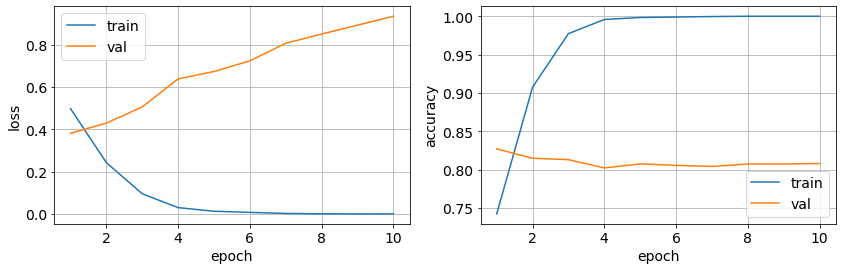

In [27]:
utilities.plot_train_val_metrics(history, metrics=('loss', 'accuracy'))

In [28]:
model.layers[0].get_weights()[0].shape

(10000, 16)

In [29]:
utilities.save_tsv(model, tokenizer, os.path.join('data', 'imdb', 'imdb'))

In [34]:
def fit_imdb(num_words, embed_d, maxlen, epochs=10):
    tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(trn_txs)

    trn_sqs = tokenizer.texts_to_sequences(trn_txs)
    trn_sqs = pad_sequences(trn_sqs, padding='post', maxlen=maxlen, truncating='post')

    tst_sqs = tokenizer.texts_to_sequences(tst_txs)
    tst_sqs = pad_sequences(tst_sqs, padding='post', maxlen=maxlen, truncating='post')
    
    model = keras.models.Sequential([
        keras.layers.Embedding(num_words, embed_d, input_length=maxlen),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(trn_sqs, trn_lbs, epochs=epochs, validation_data=(tst_sqs, tst_lbs))
    utilities.plot_train_val_metrics(history, metrics=('loss', 'accuracy'))
    
    return model, tokenizer

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 4s 4ms/step - loss: 0.6297 - accuracy: 0.7203 - val_loss: 0.5508 - val_accuracy: 0.7727
Epoch 2/10
782/782 [==============================] - 3s 3ms/step - loss: 0.4698 - accuracy: 0.8178 - va

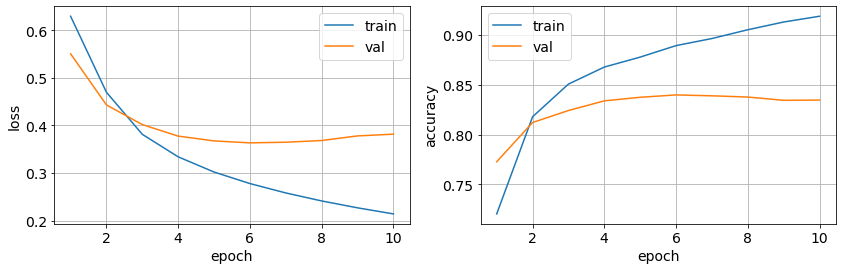

In [31]:
%%time
model, tokenizer = fit_imdb(num_words=10000, embed_d=16, maxlen=120)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 120, 1)            10000     
                                                                 
 global_average_pooling1d_8   (None, 1)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 1)                 2         
                                                                 
Total params: 10,002
Trainable params: 10,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
782/782 [==============================] - 3s 3ms/step - loss: 0.6858 - accuracy: 0.6819 - val_loss: 0.6744 - val_accuracy: 0.7100
Epoch 2/30
782/782 [==============================] - 2s 3ms/step - loss: 0.6538 - accuracy: 0.7353 - val

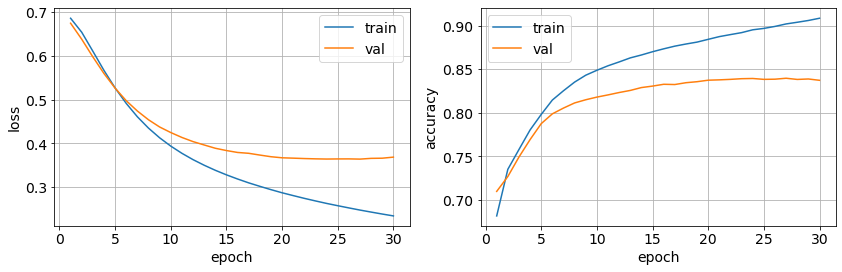

In [39]:
%%time
model, tokenizer = fit_imdb(num_words=10000, embed_d=1, maxlen=120, epochs=30)

In [40]:
utilities.embed_extremes(model, tokenizer)

   -9.4055 worst              5.7935 excellent      
   -7.5195 awful              4.9663 superb         
   -7.2237 waste              4.9569 wonderful      
   -6.6512 boring             4.8172 refreshing     
   -5.9761 disappointment     4.7126 funniest       
   -5.9077 horrible           4.6354 amazing        
   -5.7313 poorly             4.5987 wonderfully    
   -5.7244 dull               4.5130 fantastic      
   -5.6047 terrible           4.3118 perfect        
   -5.4524 poor               4.1718 favorite       
   -5.3481 lame               4.1433 loved          
   -5.2383 worse              4.0707 touching       
   -5.2065 pointless          3.8772 rare           
   -5.1981 annoying           3.8702 captures       
   -5.1857 unfunny            3.8549 pleasantly     
   -4.9241 badly              3.8108 gem            
   -4.9038 mess               3.7638 extraordinary  
   -4.8758 unfortunately      3.7590 best           
   -4.8700 fails              3.7510 enjoyed  

In [41]:
utilities.save_tsv(model, tokenizer, os.path.join('data', 'imdb', 'imdb-pool'))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 120, 1)            1000      
                                                                 
 global_average_pooling1d_6   (None, 1)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 1)                 2         
                                                                 
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
782/782 [==============================] - 3s 3ms/step - loss: 0.6872 - accuracy: 0.6340 - val_loss: 0.6779 - val_accuracy: 0.6792
Epoch 2/30
782/782 [==============================] - 2s 3ms/step - loss: 0.6624 - accuracy: 0.6918 - val_lo

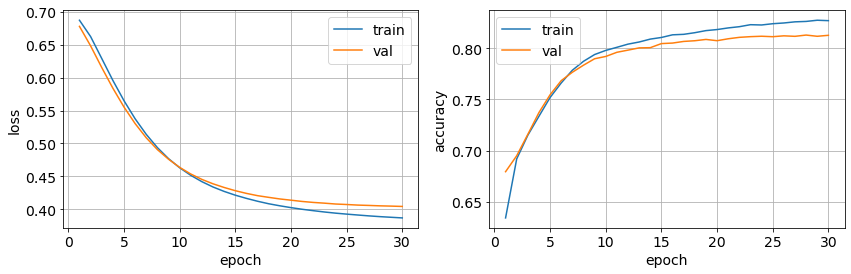

In [36]:
%%time
model, tokenizer = fit_imdb(num_words=1000, embed_d=1, maxlen=120, epochs=30)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 60, 1)             1000      
                                                                 
 global_average_pooling1d_7   (None, 1)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
782/782 [==============================] - 3s 3ms/step - loss: 0.6858 - accuracy: 0.6229 - val_loss: 0.6766 - val_accuracy: 0.6582
Epoch 2/30
782/782 [==============================] - 2s 2ms/step - loss: 0.6630 - accuracy: 0.6747 - val_lo

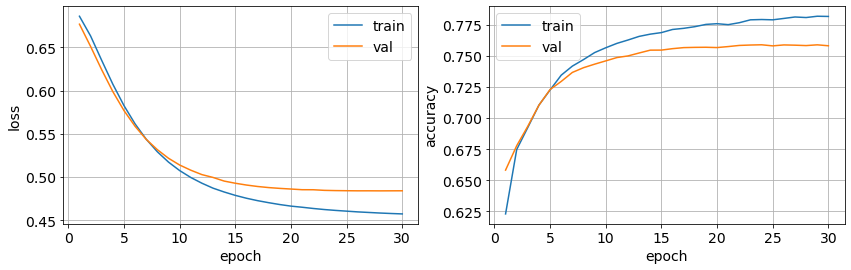

In [37]:
%%time
model, tokenizer = fit_imdb(num_words=1000, embed_d=1, maxlen=60, epochs=30)

In [38]:
utilities.embed_extremes(model, tokenizer)

   -9.2049 worst              4.8228 wonderful      
   -7.0137 awful              4.7256 amazing        
   -5.6776 waste              4.6927 excellent      
   -5.3314 worse              4.2063 unique         
   -5.3121 terrible           4.1117 superb         
   -5.2985 horrible           3.7276 fantastic      
   -5.2066 boring             3.5697 best           
   -5.0586 fails              3.3116 surprised      
   -4.9218 mess               3.2397 perfect        
   -4.7772 poorly             3.2207 loved          
   -4.6691 dull               3.2181 favorite       
   -4.5714 ridiculous         3.1994 simple         
   -4.5529 lame               3.0817 hilarious      
   -4.5208 poor               3.0793 brilliant      
   -4.4881 unfortunately      3.0688 enjoyed        
   -4.3785 badly              2.8881 fun            
   -4.1145 bad                2.7890 perfectly      
   -3.6990 crap               2.7657 masterpiece    
   -3.6039 stupid             2.6430 great    

# Subwords encoder

In [42]:
imdbsub, infosub = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteGVE4EA\imdb_reviews-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteGVE4EA\imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling ~\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteGVE4EA\imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [43]:
infosub

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/subwords8k/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Uses `tfds.deprecated.text.SubwordTextEncoder` with 8k vocab size
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~\\tensorflow_datasets\\imdb_reviews\\subwords8k\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=54.72 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    supervised_keys=('text', 'label'),
    d

In [50]:
infosub.features

FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

In [51]:
for example in imdbsub['train'].take(2):
    print(example)

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
       5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
          3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
         79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
         33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
         27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
         19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
        102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
          3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
          2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
        102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
         27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
         12,  258, 2306,   13,   91,   29,  171,   52,  229,    2, 1245,
    

In [52]:
sub_tokenizer = infosub.features['text'].encoder

for example in imdbsub['train'].take(2):
    print(sub_tokenizer.decode(example[0]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was cons

In [55]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(trn_txs)
trn_sqs = tokenizer.texts_to_sequences(trn_txs)

In [59]:
tokenizer.sequences_to_texts(trn_sqs[:1])[0]

"this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher <OOV> good name i could barely sit through it"

In [60]:
len(tokenizer.word_index)

88583

In [70]:
np.array(sub_tokenizer.subwords[:100])

array(['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br',
       'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_',
       'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_',
       'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_',
       'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_',
       'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_',
       'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_',
       'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_',
       'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_',
       'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_',
       'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_',
       'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_',
       'because_', 'ing'], dtype='<U8')

In [73]:
tokenized = sub_tokenizer.encode(trn_txs[0])
print(tokenized)
print(len(tokenized))

decoded = sub_tokenizer.decode(tokenized)
print(decoded)
print(len(trn_sqs[0]))

[62, 18, 41, 604, 927, 65, 3, 644, 7968, 21, 35, 5096, 36, 11, 43, 2948, 5240, 102, 50, 681, 7862, 1244, 3, 3266, 29, 122, 640, 2, 26, 14, 279, 438, 35, 79, 349, 384, 11, 1991, 3, 492, 79, 122, 188, 117, 33, 4047, 4531, 14, 65, 7968, 8, 1819, 3947, 3, 62, 27, 9, 41, 577, 5044, 2629, 2552, 7193, 7961, 3642, 3, 19, 107, 3903, 225, 85, 198, 72, 1, 1512, 738, 2347, 102, 6245, 8, 85, 308, 79, 6936, 7961, 23, 4981, 8044, 3, 6429, 7961, 1141, 1335, 1848, 4848, 55, 3601, 4217, 8050, 2, 5, 59, 3831, 1484, 8040, 7974, 174, 5773, 22, 5240, 102, 18, 247, 26, 4, 3903, 1612, 3902, 291, 11, 4, 27, 13, 18, 4092, 4008, 7961, 6, 119, 213, 2774, 3, 12, 258, 2306, 13, 91, 29, 171, 52, 229, 2, 1245, 5790, 995, 7968, 8, 52, 2948, 5240, 8039, 7968, 8, 74, 1249, 3, 12, 117, 2438, 1369, 192, 39, 7975]
163
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could no

In [77]:
tokenizer.sequences_to_texts(
    tokenizer.texts_to_sequences(['TensorFlow, from basics to mastery'])
)[0]

'<OOV> from <OOV> to <OOV>'

In [75]:
sub_tokenizer.decode(sub_tokenizer.encode('TensorFlow, from basics to mastery'))

'TensorFlow, from basics to mastery'

In [81]:
for c in sub_tokenizer.encode('TensorFlow, from basics to mastery'):
    print(f'{c:5} => {sub_tokenizer.decode([c])}')

 6307 => Ten
 2327 => sor
 4043 => Fl
 2120 => ow
    2 => , 
   48 => from 
 4249 => basi
 4429 => cs 
    7 => to 
 2652 => master
 8050 => y


In [85]:
len(sub_tokenizer.subwords), sub_tokenizer.vocab_size, infosub.features['text'].vocab_size

(7928, 8185, 8185)

In [90]:
'and' in sub_tokenizer.subwords, 'and_' in sub_tokenizer.subwords

(True, True)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 16)          130960    
                                                                 
 global_average_pooling1d_11  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 15s 18ms/step - loss: 0.6917 - accuracy: 0.5456 - val_loss: 0.6887 - val_accuracy: 0.6226
Epoch 2/10
782/782 [==============================] - 14s 17ms/step - loss: 0.6819 - accuracy: 0.6475

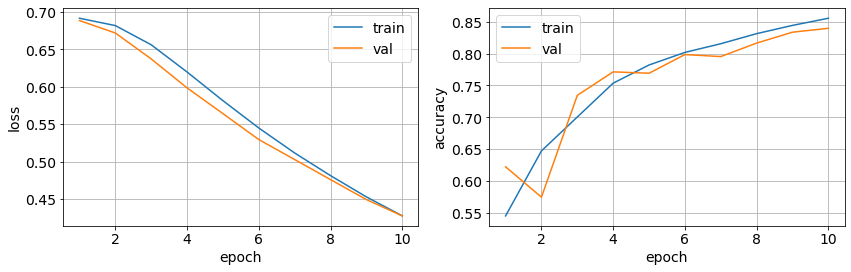

In [95]:
%%time

num_words = sub_tokenizer.vocab_size
embed_d = 16
epochs=10

trn_sqs_sub = []
for p, _ in imdbsub['train']:
    trn_sqs_sub.append(p.numpy())
trn_sqs_sub = pad_sequences(trn_sqs_sub, padding='post', truncating='post')

tst_sqs_sub = []
for p, _ in imdbsub['test']:
    tst_sqs_sub.append(p.numpy())
tst_sqs_sub = pad_sequences(tst_sqs_sub, padding='post', truncating='post')

model = keras.models.Sequential([
    keras.layers.Embedding(num_words, embed_d),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1, activation='sigmoid'),
])
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trn_sqs_sub, trn_lbs, epochs=epochs, validation_data=(tst_sqs_sub, tst_lbs))
utilities.plot_train_val_metrics(history, metrics=('loss', 'accuracy'))

In [101]:
def fit_rmdb_sub(embed_d, epochs=10, batch_size=32, dense_neuron=0):
    if dense_neuron == 0:
        model = keras.models.Sequential([
            keras.layers.Embedding(sub_tokenizer.vocab_size, embed_d),
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
    else:
        model = keras.models.Sequential([
            keras.layers.Embedding(sub_tokenizer.vocab_size, embed_d),
            keras.layers.GlobalAveragePooling1D(),
            keras.layers.Dense(dense_neuron, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(
        imdbsub['train'].padded_batch(batch_size),
        epochs=epochs,
        validation_data=imdbsub['test'].padded_batch(batch_size)
    )
    utilities.plot_train_val_metrics(history, metrics=('loss', 'accuracy'))
    
    return model

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 16)          130960    
                                                                 
 global_average_pooling1d_16  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
782/782 [==============================] - 7s 8ms/step - loss: 0.6811 - accuracy: 0.6238 - val_loss: 0.6602 - val_accuracy: 0.6955
Epoch 2/30
782/782 [==============================] - 7s 8ms/step - loss: 0.6197 - accuracy: 0.7510 - v

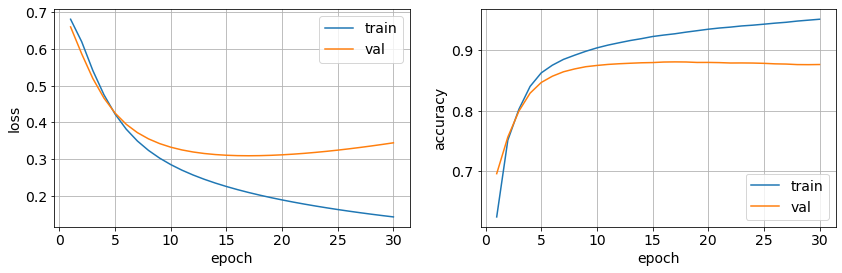

In [102]:
%%time
model = fit_rmdb_sub(embed_d=16, epochs=30, batch_size=32)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 64)          523840    
                                                                 
 global_average_pooling1d_17  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 523,905
Trainable params: 523,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 [==============================] - 17s 21ms/step - loss: 0.6649 - accuracy: 0.6410 - val_loss: 0.6111 - val_accuracy: 0.7182
Epoch 2/20
782/782 [==============================] - 18s 23ms/step - loss: 0.5341 - accuracy: 0.7957

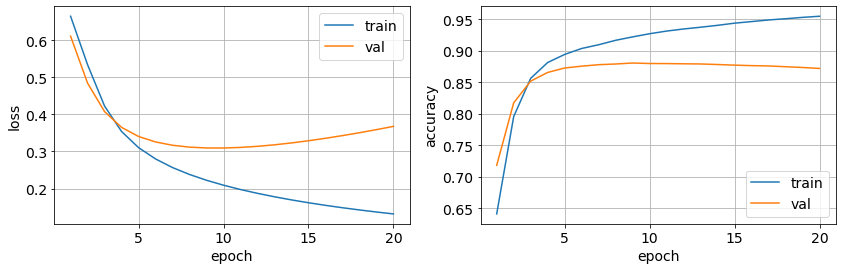

In [103]:
%%time
model = fit_rmdb_sub(embed_d=64, epochs=20, batch_size=32)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 16)          130960    
                                                                 
 global_average_pooling1d_18  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_22 (Dense)            (None, 6)                 102       
                                                                 
 dense_23 (Dense)            (None, 1)                 7         
                                                                 
Total params: 131,069
Trainable params: 131,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
782/782 [==============================] - 7s 8ms/step - loss: 0.6695 - accuracy: 0.6379 - val_loss: 0

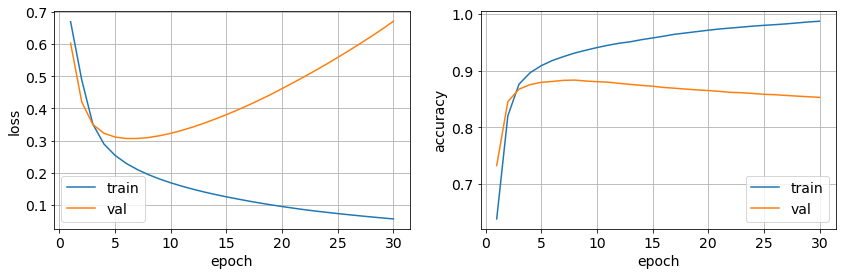

In [104]:
%%time
model = fit_rmdb_sub(embed_d=16, epochs=30, batch_size=32, dense_neuron=6)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 64)          523840    
                                                                 
 global_average_pooling1d_19  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_24 (Dense)            (None, 6)                 390       
                                                                 
 dense_25 (Dense)            (None, 1)                 7         
                                                                 
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
782/782 [==============================] - 18s 22ms/step - loss: 0.6050 - accuracy: 0.6930 - val_loss:

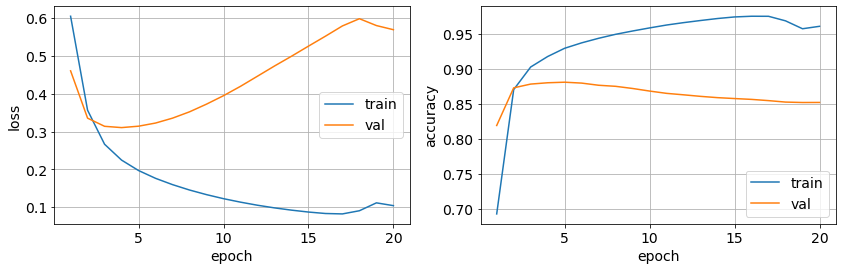

In [105]:
%%time
model = fit_rmdb_sub(embed_d=64, epochs=20, batch_size=32, dense_neuron=6)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, None, 1)           8185      
                                                                 
 global_average_pooling1d_23  (None, 1)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_29 (Dense)            (None, 1)                 2         
                                                                 
Total params: 8,187
Trainable params: 8,187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
782/782 [==============================] - 5s 6ms/step - loss: 0.6916 - accuracy: 0.5658 - val_loss: 0.6891 - val_accuracy: 0.6539
Epoch 2/60
782/782 [==============================] - 5s 6ms/step - loss: 0.6841 - accuracy: 0.6626 - val_l

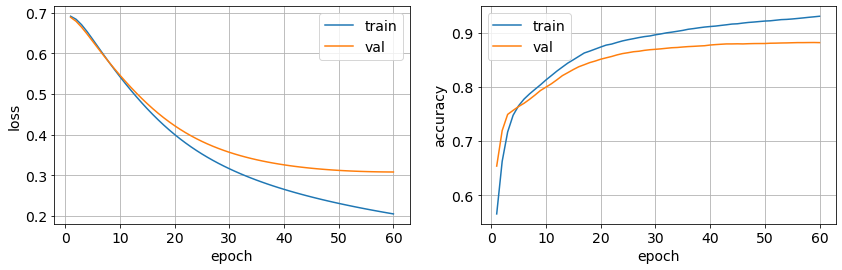

In [109]:
%%time
model = fit_rmdb_sub(embed_d=1, epochs=60, batch_size=32)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 16)          130960    
                                                                 
 global_average_pooling1d_21  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
391/391 [==============================] - 8s 18ms/step - loss: 0.6889 - accuracy: 0.5856 - val_loss: 0.6820 - val_accuracy: 0.6968
Epoch 2/30
391/391 [==============================] - 7s 17ms/step - loss: 0.6663 - accuracy: 0.6984 -

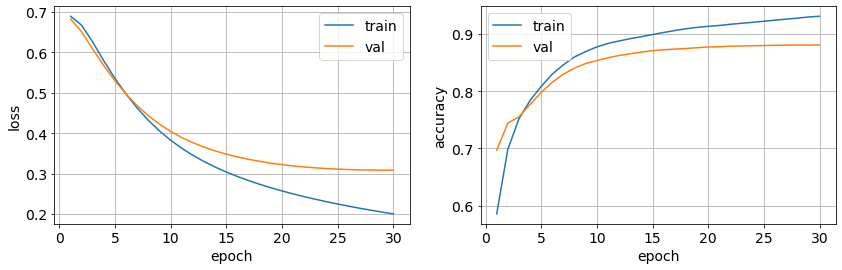

In [107]:
%%time
model = fit_rmdb_sub(embed_d=16, epochs=30, batch_size=64)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 16)          130960    
                                                                 
 global_average_pooling1d_22  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_28 (Dense)            (None, 1)                 17        
                                                                 
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6597 - accuracy: 0.6662 - val_loss: 0.6046 - val_accuracy: 0.7216
Epoch 2/30
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5306 - accuracy: 0.80

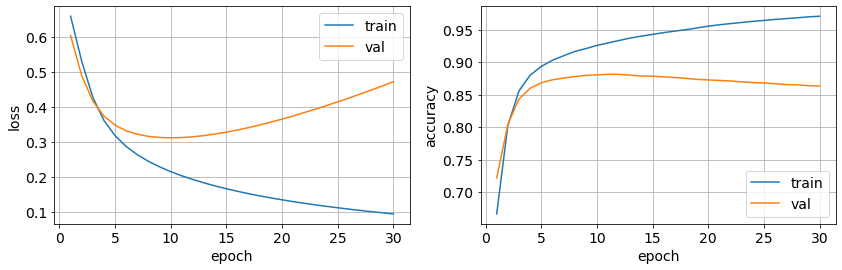

In [108]:
%%time
model = fit_rmdb_sub(embed_d=16, epochs=30, batch_size=16)